## term analysis and statistics

### encoding TNFD glossary terms

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2', device='cpu')
df_tfnd_glossary_2023["embedding"] = df_tfnd_glossary_2023["Definition"].apply(lambda term: model.encode(term, convert_to_numpy=True))

In [ ]:
df_tfnd_glossary_2023.to_json("data/df_tfnd_glossary_2023_embedded.json", orient="records")

In [7]:
df_tfnd_glossary_2023 = pd.read_json("data/df_tfnd_glossary_2023_embedded.json", orient="records")
df_tfnd_glossary_2023["embedding"] = df_tfnd_glossary_2023["embedding"].apply(lambda x: np.array(x, dtype=np.float32))

In [8]:
df_tfnd_glossary_2023

,Unnamed: 0,Term,Definition,embedding
0,0,Abiotic flows,Abiotic flows are contributions to benefits fr...,"[-0.029361257, 0.006075624, -0.018649256, 0.04..."
1,1,Acute risk,"Occurrence of short-term, specific events that...","[-0.038341668, -0.0003466105, 0.009580128, -0...."
2,2,Adaptation,Adjustment in natural or human systems to a ne...,"[-0.022162942, -0.044189833, 0.0013946677, -0...."
3,3,Additional conservation actions,A broad range of activities intended to benefi...,"[0.009307631, 0.02553423, -0.012623155, 0.0058..."
4,4,Additional disclosure metrics,Metrics suggested by the TNFD that a company o...,"[-0.023433544, 0.009369389, -0.014957044, -0.0..."
...,...,...,...,...
352,352,Water sources,Water sources include water withdrawn from sur...,"[0.017979847, 0.00714735, 0.009741537, 0.02206..."
353,353,Water stress (areas of),Water stressed (region): defined in three lev...,"[-0.01709339, -0.08745881, -0.0017973423, -0.0..."
354,354,Water withdrawal,The sum of all water drawn into the boundaries...,"[0.013102424, -0.07435216, 0.013924917, 0.0146..."
355,355,Wild species,Refers to populations of any native species th...,"[-0.007327114, -0.020553412, 0.007337141, -0.0..."


### relevant terms

In [9]:
terms = ['Nature-related systemic risks', 
        'Nature-related physical risks',
        'Nature-related transition risks',
        'Nature-related opportunities',
        'Ecosystem protection, restoration and regeneration opportunity']
risks_opportunities_tnfd_glossary = df_tfnd_glossary_2023[df_tfnd_glossary_2023['Term'].isin(terms)]

In [9]:
risk_glossary_terms = ['Ecosystem stability risk', 
                       'Nature-related systemic risks',
                       'Nature-related transition risks']
opportunities_terms = ['Sustainable use of natural resources opportunity',
                       'Ecosystem protection, restoration and regeneration opportunity']


### fetching relevant chunks from the ECC database based on the glossary terms

In [1]:
from glossary_similarity import fetch_chunks_for_term_for_years_biodiv_subset, get_biodiversity_subset

/Users/joey/Desktop/uni/Master/neo4j_repository/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joey/Desktop/uni/Master/neo4j_repository/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
time_frame = [2015,2016,2017,2018,2019,2020,2021,2022,2023]

In [10]:
all_terms_similar_embeddings = pd.DataFrame()

# fetch biodiv. subset from database
driver, biodiversity_subset = get_biodiversity_subset(time_frame,chunks_per_year=100000,streamlit_secret=False)

for i, row in risks_opportunities_tnfd_glossary.iterrows():
    
    term = row['Term']
    embedding = row['embedding']

    print(f'processing term {term} [{i} out of {len(df_tfnd_glossary_2023)}] ..')

    chunks = fetch_chunks_for_term_for_years_biodiv_subset(driver,
                                                           time_frame,
                                                           term,
                                                           embedding,
                                                           biodiversity_subset, 
                                                           streamlit_secret=False,
                                                           chunks_per_year=100)
    results = pd.DataFrame(chunks)
    results['term_embedding'] = [np.array(embedding, dtype=np.float32)] * len(results)
    results['term'] = term

    print(f'results for {term}: {len(results)}')
    
    all_terms_similar_embeddings = pd.concat([all_terms_similar_embeddings, results])


returning biodiv also
processing term Ecosystem protection, restoration and regeneration opportunity [80 out of 357] ..
results for Ecosystem protection, restoration and regeneration opportunity: 66
processing term Nature-related opportunities [192 out of 357] ..
results for Nature-related opportunities: 86
processing term Nature-related physical risks [193 out of 357] ..
results for Nature-related physical risks: 64
processing term Nature-related systemic risks [196 out of 357] ..
results for Nature-related systemic risks: 43
processing term Nature-related transition risks [197 out of 357] ..
results for Nature-related transition risks: 60


In [ ]:
all_terms_similar_embeddings.to_pickle('data/alltermssimilarembeddings_n100_nobiodiv_subset.pkl')

In [33]:
all_terms_similar_embeddings = pd.read_pickle('data/all_terms_n100_biodiv_subset.pkl')

In [34]:
all_terms_similar_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9530 entries, 0 to 61
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9530 non-null   object 
 1   embedding       9530 non-null   object 
 2   chunk_text      9530 non-null   object 
 3   name            9530 non-null   object 
 4   year            9530 non-null   float64
 5   month           9530 non-null   float64
 6   company         9530 non-null   object 
 7   industry        9530 non-null   object 
 8   score           9530 non-null   float64
 9   term_embedding  9530 non-null   object 
 10  term            9530 non-null   object 
dtypes: float64(3), object(8)
memory usage: 893.4+ KB


In [35]:
similarity_stats_n100 = all_terms_similar_embeddings.groupby(["term","year"])["score"].agg(["mean", "std", "max", "min", "count"]).reset_index()

# Rank terms based on mean similarity score (descending order)
similarity_stats_n100 = similarity_stats_n100.sort_values(by=["term","year","mean"], ascending=False)

In [38]:
similarity_stats_n100[similarity_stats_n100['term'].isin(terms)].head(5)

,term,year,mean,std,max,min,count
1034,Nature-related transition risks,2022.0,0.837821,0.019032,0.874456,0.811410,21
1033,Nature-related transition risks,2021.0,0.833508,0.022705,0.885316,0.810901,20
1032,Nature-related transition risks,2020.0,0.816932,0.005521,0.830113,0.810815,10
1031,Nature-related transition risks,2019.0,0.825882,0.006244,0.832803,0.820670,3
1030,Nature-related transition risks,2017.0,0.823246,0.013629,0.838182,0.811486,3


## Plotting

### basic plots

In [22]:
import textwrap

import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# this allows for inline representation of matplotlib graphs
%matplotlib inline

In [50]:
def plot_term_trends_over_time(df, top_n=20, bin_size=2):
    """
    Plots how terms have increased over time in similarity score.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'year_bin', 'term', and 'score' columns.
        top_n (int): Number of terms to display with the **highest increase** in their similarity score over time.
    """
    

    df["year_bin"] = (df["year"] // bin_size) * bin_size  # Group into bins of `bin_size` years

    # Compute mean similarity score per term per time period
    term_trends = df.groupby(["year_bin", "term"])["score"].mean().reset_index()

    # Pivot to get terms as rows, time bins as columns
    term_pivot = term_trends.pivot(index="term", columns="year_bin", values="score")

    # Compute change from first to last available time period
    term_pivot["score_change"] = term_pivot.iloc[:, -1] - term_pivot.iloc[:, 0]  # Last column - first column

    # Get top N increasing terms
    top_terms = term_pivot.nlargest(top_n, "score_change").index.tolist()

    # Filter dataset to include only the top increasing terms
    df_filtered = term_trends[term_trends["term"].isin(top_terms)]

    # Plot with Plotly
    fig = px.line(
        df_filtered, x="year_bin", y="score", color="term",
        markers=True, title=f"Top {top_n} Terms with Highest Score Increase Over Time",
        labels={"year_bin": "Time Period", "score": "Mean Similarity Score"},
    )

    # Improve layout
    fig.update_layout(
        xaxis=dict(title="Year Bin", tickmode="array", tickvals=df["year_bin"].unique()),
        yaxis=dict(title="Mean Similarity Score"),
        height=700,
        legend_title="Term",
    )

    fig.show()

In [54]:
plot_term_trends_over_time(all_terms_similar_embeddings,25,2)

In [23]:
df = all_terms_similar_embeddings

df["month"] = df["month"].fillna(1).astype(int)

# Convert year & month into a continuous time format
df["time"] = df["year"] + (df["month"] - 1) / 12
#%%
# Function to wrap long text
def wrap_text(text, width=50):
    return "<br>".join(textwrap.wrap(text, width=width))
#%%
# Apply text wrapping to chunk text

df["wrapped_chunk"] = df["chunk_text"].apply(lambda x: wrap_text(str(x), width=50))
#%%
# Create scatter plot
fig = px.scatter(
    df,
    x="time",
    y="score",
    hover_data=["term", "wrapped_chunk", "company"],
    title="score Trends Over Time",
    labels={"time": "Year", "similarity": "Similarity Score (1 = Term Embedding)"}
)

# Adjust marker size & opacity for readability
fig.update_traces(marker=dict(size=5, opacity=0.5))

# Improve hover template with line breaks
fig.update_traces(hovertemplate="<b>Year:</b> %{x:.1f}<br>"
                                "<b>Similarity Score:</b> %{y:.3f}<br>"
                                "<b>Term:</b> %{customdata[0]}<br>"
                                "<b>Statement:</b> %{customdata[1]}<br>"
                                "<b>Company:</b> %{customdata[2]}")

# Format x-axis to show only years
fig.update_layout(
    showlegend=False,  # Remove legend
    xaxis=dict(
        tickmode="array",
        tickvals=df["year"].unique(),  # Show only year markers
        ticktext=[str(y) for y in df["year"].unique()],
        title="<b>Year</b>"
    ),
    yaxis=dict(range=[0, 1.1]),
    height=700
)

fig.show()

### density functions

In [ ]:
def plot_similarity_density(df):
    """
    Plots the Gaussian-like similarity distribution for all terms across different years.
    Parameters:
        df (pd.DataFrame): DataFrame containing 'year' and 'score' columns.
    """
    # Ensure necessary columns exist
    if "year" not in df or "score" not in df:
        raise ValueError("DataFrame must contain 'year' and 'score' columns")

    plt.figure(figsize=(10, 6))

    # Plot KDE distribution per year
    unique_years = sorted(df["year"].unique())
    for year in unique_years:
        subset = df[df["year"] == year]
        sns.kdeplot(subset["score"], label=str(year), fill=True, alpha=0.4)

    # Formatting
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.title("Similarity Score Distribution Over Time")
    plt.xlim(0.5, 1)  # Restrict similarity score range
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.6)


plot_similarity_density(all_terms_similar_embeddings)


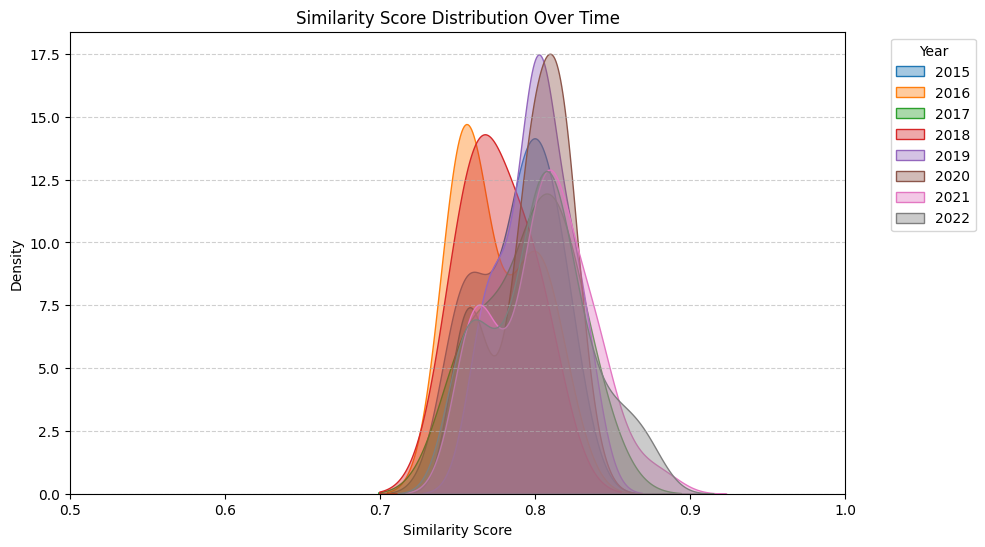

In [29]:
plot_similarity_density(all_terms_similar_embeddings)


### scatterplots

In [30]:
def scatterplot_by_terms(df, terms):
    # Ensure necessary columns exist
    required_cols = ["year", "score", "term", "chunk_text", "company", "industry"]
    df["time"] = df["year"] + (df["month"] - 1) / 12
    # Function to wrap long text
    def wrap_text(text, width=50):
        return "<br>".join(textwrap.wrap(str(text), width=width))

    # Apply text wrapping to statements
    df["wrapped_chunk"] = df["chunk_text"].apply(lambda x: wrap_text(x, width=50))

    # Get unique terms
    if not terms:
        unique_terms = df["term"].unique()
    else:
        unique_terms = terms

    fig = go.Figure()

    # Assign colors dynamically
    colors = px.colors.qualitative.Set1  # Pick a predefined color palette

    for _, term in enumerate(unique_terms):
        term_df = df[df["term"] == term]
        color = "black"

        trace = go.Scattergl(
            x=term_df["time"],
            y=term_df["score"],
            mode="markers",
            customdata=term_df[["id", "score", "company", "industry", "wrapped_chunk"]],
            hovertemplate=(
                "<b>ID:</b> %{customdata[0]}<br>" +
                "<b>Similarity score (cosine):</b> %{customdata[1]:.3f}<br>" +
                "<b>Company:</b> %{customdata[2]}<br>" +
                "<b>Industry:</b> %{customdata[3]}<br>" +
                "<b>Statement:</b> %{customdata[4]}<br>"
            ),
            marker=dict(
                size=6,
                opacity=0.7,
                color=color,
                showscale=False
            ),
            name=term
        )
                    

        fig.add_trace(trace)


    # Update layout
    fig.update_layout(
        title="<b>Similarity-Based score (cosine) Over Time by Term</b>",
        xaxis=dict(title="<b>Year</b>", tickmode="linear", dtick=1),
        yaxis=dict(title="<b>Similarity Score</b>"),
        hovermode="closest",
        plot_bgcolor="white",
        paper_bgcolor="white",
        font=dict(family="Arial", size=12),
        legend_title="Terms",
        height=700
    )

    fig.show()

In [31]:
terms = ['Nature-related systemic risks', 
        'Nature-related physical risks',
        'Nature-related transition risks',
        'Nature-related opportunities',
        'Ecosystem protection, restoration and regeneration opportunity']
scatterplot_by_terms(all_terms_similar_embeddings,terms)

In [39]:
def scatterplot_compare_terms(df1, df2, label1="Dataset 1", label2="Dataset 2"):
    """
    Plots similarity scores over time from two different datasets with distinct colors,
    including a subtle mean trend line for each dataset.
    """
    required_cols = ["year", "score", "term", "chunk_text", "company", "industry", "month"]
    for df in [df1, df2]:
        for col in required_cols:
            if col not in df:
                raise ValueError(f"DataFrame is missing required column: {col}")

    df1["time"] = df1["year"] + (df1["month"] - 1) / 12
    df2["time"] = df2["year"] + (df2["month"] - 1) / 12

    def wrap_text(text, width=50):
        return "<br>".join(textwrap.wrap(str(text), width=width))

    df1["wrapped_chunk"] = df1["chunk_text"].apply(lambda x: wrap_text(x, width=50))
    df2["wrapped_chunk"] = df2["chunk_text"].apply(lambda x: wrap_text(x, width=50))

    unique_terms = set(df1["term"].unique()).union(set(df2["term"].unique()))

    fig = go.Figure()

    # Assign colors
    color1 = "black"
    color2 = "lightgreen"
    mean_color1 = "gray"
    mean_color2 = "green"

    for term in unique_terms:
        term_df1 = df1[df1["term"] == term]
        term_df2 = df2[df2["term"] == term]

        if not term_df1.empty:
            fig.add_trace(go.Scattergl(
                x=term_df1["time"], y=term_df1["score"], mode="markers",
                marker=dict(size=8, opacity=0.7, color=color1),
                customdata=term_df1[["id", "score", "company", "industry", "wrapped_chunk"]],
                hovertemplate="<b>ID:</b> %{customdata[0]}<br>"
                              "<b>Similarity score (cosine):</b> %{customdata[1]:.3f}<br>"
                              "<b>Company:</b> %{customdata[2]}<br>"
                              "<b>Industry:</b> %{customdata[3]}<br>"
                              "<b>Statement:</b> %{customdata[4]}<br>",
                name=f"{label1}: {term}"
            ))

        if not term_df2.empty:
            fig.add_trace(go.Scattergl(
                x=term_df2["time"], y=term_df2["score"], mode="markers",
                marker=dict(size=6, opacity=0.9, color=color2),
                customdata=term_df2[["id", "score", "company", "industry", "wrapped_chunk"]],
                hovertemplate="<b>ID:</b> %{customdata[0]}<br>"
                              "<b>Similarity score (cosine):</b> %{customdata[1]:.3f}<br>"
                              "<b>Company:</b> %{customdata[2]}<br>"
                              "<b>Industry:</b> %{customdata[3]}<br>"
                              "<b>Statement:</b> %{customdata[4]}<br>",
                name=f"{label2}: {term}"
            ))

    # Compute mean similarity per year
    mean_df1 = df1.groupby("year")["score"].mean().reset_index()
    mean_df2 = df2.groupby("year")["score"].mean().reset_index()

    # Add trend lines
    fig.add_trace(go.Scatter(
        x=mean_df1["year"], y=mean_df1["score"], mode="lines",
        line=dict(color=mean_color1, width=2, dash="dash"),
        name=f"Mean {label1}"
    ))

    fig.add_trace(go.Scatter(
        x=mean_df2["year"], y=mean_df2["score"], mode="lines",
        line=dict(color=mean_color2, width=2, dash="dash"),
        name=f"Mean {label2}"
    ))

    # Update layout
    fig.update_layout(
        title="<b>Comparison of Similarity Scores Over Time</b>",
        xaxis=dict(title="<b>Year</b>", tickmode="linear", dtick=1),
        yaxis=dict(title="<b>Similarity Score</b>"),
        hovermode="closest",
        plot_bgcolor="white",
        paper_bgcolor="white",
        font=dict(family="Arial", size=12),
        legend_title="Dataset & Terms",
        height=700
    )

    fig.show()

In [43]:
materiality_terms = ['Biodiversity', 'Double materiality', 'Biodiversity offsets', 'Cut off dates (related to no- deforestation and no-conversion commitments)']
terms_mat = ['Biodiversity', 'Biodiversity offsets']

biodiversity = all_terms_similar_embeddings.where(all_terms_similar_embeddings['term']==terms_mat[0])

biodiversity_offsets = all_terms_similar_embeddings.where(all_terms_similar_embeddings['term']==terms_mat[1])

scatterplot_compare_terms(biodiversity,biodiversity_offsets,'Biodiversity', 'Biodiversity offsets')

In [45]:
def scatterplot_compare_terms_jitter(df1, df2, label1="Dataset 1", label2="Dataset 2"):
    """
    Plots similarity scores over time from two different datasets with distinct colors.

    Parameters:
        df1 (pd.DataFrame): First dataset containing 'year', 'score', 'term', 'chunk_text', 'company', and 'industry'.
        df2 (pd.DataFrame): Second dataset with the same structure as df1.
        label1 (str): Label for the first dataset in the legend.
        label2 (str): Label for the second dataset in the legend.
    """
    # Ensure necessary columns exist
    required_cols = ["year", "score", "term", "chunk_text", "company", "industry", "month"]
    for df in [df1, df2]:
        for col in required_cols:
            if col not in df:
                raise ValueError(f"DataFrame is missing required column: {col}")

    # Convert year & month into a continuous time format
    df1["time"] = df1["year"] + (df1["month"] - 1) / 12
    df2["time"] = df2["year"] + (df2["month"] - 1) / 12

    # Add small jitter to reduce overlap
    df1["time"] += np.random.normal(0, 0.001, size=len(df1))  # Small randomness in x-axis
    df2["time"] += np.random.normal(0, 0.001, size=len(df2))

    # Function to wrap long text
    def wrap_text(text, width=50):
        return "<br>".join(textwrap.wrap(str(text), width=width))

    # Apply text wrapping
    df1["wrapped_chunk"] = df1["chunk_text"].apply(lambda x: wrap_text(x))
    df2["wrapped_chunk"] = df2["chunk_text"].apply(lambda x: wrap_text(x))

    # Get unique terms across both datasets
    unique_terms = set(df1["term"].unique()).union(set(df2["term"].unique()))

    fig = go.Figure()

    # Assign two distinct colors
    color1 = "black"
    color2 = "springgreen"

    for term in unique_terms:
        # Filter for the term in each dataset
        term_df1 = df1[df1["term"] == term]
        term_df2 = df2[df2["term"] == term]

        # Plot first dataset points (higher opacity for better visibility)
        if not term_df1.empty:
            fig.add_trace(go.Scattergl(
                x=term_df1["time"],
                y=term_df1["score"],
                mode="markers",
                marker=dict(size=6, opacity=0.7, color=color1),  # Increased opacity and size
                customdata=term_df1[["id", "score", "company", "industry", "wrapped_chunk"]],
                hovertemplate=(
                    "<b>ID:</b> %{customdata[0]}<br>"
                    "<b>Similarity score (cosine):</b> %{customdata[1]:.3f}<br>"
                    "<b>Company:</b> %{customdata[2]}<br>"
                    "<b>Industry:</b> %{customdata[3]}<br>"
                    "<b>Statement:</b> %{customdata[4]}<br>"
                ),
                name=f"{label1}: {term}"
            ))

        # Plot second dataset points (lower opacity to reveal overlap)
        if not term_df2.empty:
            fig.add_trace(go.Scattergl(
                x=term_df2["time"],
                y=term_df2["score"],
                mode="markers",
                marker=dict(size=8, opacity=0.5, color=color2),  # Lower opacity to reduce clutter
                customdata=term_df2[["id", "score", "company", "industry", "wrapped_chunk"]],
                hovertemplate=(
                    "<b>ID:</b> %{customdata[0]}<br>"
                    "<b>Similarity score (cosine):</b> %{customdata[1]:.3f}<br>"
                    "<b>Company:</b> %{customdata[2]}<br>"
                    "<b>Industry:</b> %{customdata[3]}<br>"
                    "<b>Statement:</b> %{customdata[4]}<br>"
                ),
                name=f"{label2}: {term}"
            ))

    # Update layout
    fig.update_layout(
        title="<b>Comparison of Similarity Scores Over Time</b>",
        xaxis=dict(title="<b>Year</b>", tickmode="linear", dtick=1),
        yaxis=dict(title="<b>Similarity Score</b>"),
        hovermode="closest",
        plot_bgcolor="white",
        paper_bgcolor="white",
        font=dict(family="Arial", size=12),
        legend=dict(
            title="Dataset & Terms",
            x=1.05,  # Move legend slightly right
            y=1, 
            tracegroupgap=5,  # Reduce gap between legend items
            font=dict(size=10),  # Reduce font size
        ),
        height=700
    )

    fig.show()

In [ ]:
# for comparing the same data at different granularities
scatterplot_compare_terms_jitter(biodiversity,biodiversity_offsets,'Biodiversity', 'Biodiversity offsets')

### boxplots

In [47]:
def boxplot_terms_over_time(df, terms, bin_size=2):
    """
    Creates boxplots of similarity score density over time for selected terms.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'year', 'score', and 'term'.
        terms (list): List of terms to plot.
        bin_size (int): The number of years per bin (default: 2 years).
    """
    # Ensure necessary columns exist
    required_cols = ["year", "score", "term"]
    for col in required_cols:
        if col not in df:
            raise ValueError(f"Missing required column: {col}")

    # Filter dataframe for selected terms
    df_filtered = df[df["term"].isin(terms)].copy()

    # Create bins for time periods
    df_filtered["year_bin"] = (df_filtered["year"] // bin_size) * bin_size  # Group into bins of `bin_size` years

    # Assign distinct colors dynamically
    color_palette = px.colors.qualitative.Set1  # Choose a distinct color set
    term_colors = {term: color_palette[i % len(color_palette)] for i, term in enumerate(terms)}

    # Create boxplot using Plotly
    fig = px.box(
        df_filtered,
        x="year_bin",
        y="score",
        color="term",
        points="all",  # Show all individual points in the boxplot
        title="Similarity Score Distribution Over Time",
        labels={"year_bin": "Time Period", "score": "Similarity Score"},
        category_orders={"year_bin": sorted(df_filtered["year_bin"].unique())},
        color_discrete_map=term_colors  # Assign distinct colors per term
    )

    # Update layout for better readability
    fig.update_layout(
        xaxis=dict(title="Year (Binned)", tickmode="linear", dtick=bin_size),
        yaxis=dict(title="Similarity Score"),
        boxmode="group",  # Group boxplots per time period
        height=700
    )

    fig.show()

In [48]:
risk_glossary_term = ['Nature-related physical risks']

boxplot_terms_over_time(all_terms_similar_embeddings,risk_glossary_term)